In [6]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Dropout,BatchNormalization,Activation,ZeroPadding2D,AveragePooling2D,MaxPooling2D,Add,AveragePooling2D,Flatten,Dense,Input
from keras.utils import to_categorical
from keras.initializers import glorot_uniform,glorot_normal
from keras.optimizers import Adadelta
from keras import backend as k
from keras.engine.input_layer import Input

from keras.models import Model, load_model

#Set to mini batch
batch_size = 128
#the number of classes we want to classify 0 --- 9
num_classes =10
#the size of the image in the mnist dataset
img_rows,img_columns = 28 ,28
#load the data to a trainning and testing
(x_train_data,y_train),(x_test_data,y_test) = mnist.load_data()
#changing the shapes to fit as we are using tensorflow as a backend
x_train = x_train_data.reshape(x_train_data.shape[0],img_rows,img_columns,1)
x_test = x_test_data.reshape(x_test_data.shape[0],img_rows,img_columns,1)
input_shape = (img_rows,img_columns,1)

#change the type for calcuations
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#normilize the values
x_train /=255
x_test /=255

#convert the class vector to a binary matrix 
#the values a represnted as 0 0 0 0 0 0 0 0 0 0 
# and there will be one on the correct class
y_train = to_categorical(y_train,num_classes)
y_test = to_categorical(y_test,num_classes)

In [7]:
def convolutional_block(X,f,filters,stage,block,s = 2):

    #define the name basis
    conv_name_base = "res" + str(stage)+block + "_branch"
    #batch normailization name basis
    bn_name_base = "bn" + str(stage)+block+ "_branch"
    #get the filters
    f1,f2,f3 = filters
    #save the shortcut value
    x_shortcut = X
    #creat the main path
    #create the first layer
    X = Conv2D(f1,kernel_size = (1,1),strides = (s,s),name = conv_name_base +'2a',padding= 'valid'
               ,kernel_initializer=glorot_normal(seed = 0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base +'2a')(X)
    X = Activation('relu')(X)
    #create the second layer
    X = Conv2D(f2,kernel_size = (f,f),strides = (1,1),name = conv_name_base +'2b',padding= 'same'
               ,kernel_initializer=glorot_normal(seed = 0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base +'2b')(X)
    X = Activation('relu')(X)
    #create the Third layer
    X = Conv2D(f3,kernel_size = (1,1),strides = (1,1),name = conv_name_base +'2c',padding= 'valid'
               ,kernel_initializer=glorot_normal(seed = 0))(X)
    X = BatchNormalization(axis = 3,name = bn_name_base +'2c')(X)
    X = Activation('relu')(X)
    
    #create the shortcut path
    #the filter size is the same as the last one so they could match
    x_shortcut = Conv2D(f3,kernel_size = (1,1),strides = (s,s),name = conv_name_base +'1',padding= 'valid'
               ,kernel_initializer=glorot_normal(seed = 0))(x_shortcut)
    x_shortcut = BatchNormalization(axis = 3,name = bn_name_base +'1')(x_shortcut)
    
    X = Add()([X,x_shortcut])
    X = Activation('relu')(X)
    
    return X

In [8]:
def identity_Block(X,f,filters,stage,block):
    
    #define the name basis
    conv_name_base = "res" + str(stage)+block + "_branch"
    #batch normailization name basis
    bn_name_base = "bn" + str(stage)+block+ "_branch"
    
    #get the filters
    f1,f2,f3 = filters
    #get the shorcut pass
    x_shortcut = X
    
    #create the main path which will hold the conv layers
    
    #First layer main path
    X = Conv2D(f1,kernel_size = (1,1),strides = (1,1),padding='valid',name = conv_name_base + '2a'
               ,kernel_initializer=glorot_normal(seed=0))(X)
    X = BatchNormalization(axis=3,name = bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    #second layer main path
    X = Conv2D(f2,kernel_size = (f,f),strides=(1,1),padding='same',name = conv_name_base + '2b'
               ,kernel_initializer = glorot_normal(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
               
    
    #Thrid layer in main path
    X = Conv2D(f3,kernel_size = (1,1),strides = (1,1),padding= 'valid',name = conv_name_base +'2c',
              kernel_initializer = glorot_normal(seed = 0))(X)               
    X = BatchNormalization(axis = 3,name = bn_name_base + '2c')(X)
    #adding the shortcut path
    X = Add()([X ,x_shortcut])
    X = Activation('relu')(X)
               

    return X

(28, 28)


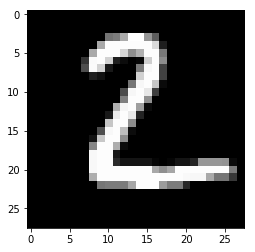

In [4]:
pixels = x_test_data[1]
pixels = np.array(pixels,'uint8')
print(pixels.shape)
pixels  = pixels.reshape(28,28)
plt.imshow(pixels,cmap='gray')
plt.show()

In [52]:

model_input = Input(input_shape)


X = ZeroPadding2D(padding = (3,3))(model_input)

#stage 1
X = Conv2D(filters = 32,kernel_size = (7,7),strides= (2,2),name='conv1'
               ,kernel_initializer=glorot_uniform(seed=0))(X)
X = BatchNormalization(axis = 3,name= 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3,3),strides=(2,2))(X)

X = convolutional_block(X = X,f = 3, filters =[32,32,64],stage = 2,block = 'a',s = 2)

X = Flatten()(X)

X = Dense(num_classes,activation='softmax',name = 'fc' + str(num_classes)
              ,kernel_initializer = glorot_uniform(seed = 0))(X)

model_object = Model(inputs = model_input,outputs = X,name ='TestNet')


In [53]:
model_object.summary()#3

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_12 (ZeroPadding2 (None, 34, 34, 1)    0           input_12[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 32)   1600        zero_padding2d_12[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 32)   128         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [54]:
#setup the model for training
model_object.compile(loss = 'categorical_crossentropy',
              optimizer = Adadelta(),
              #We can specify more metrics that we want to monitor
              metrics=['accuracy'])



In [55]:
#train the model
model_object.fit(x = x_train,y = y_train,
          batch_size = batch_size,
          epochs = 15,
        #this will show is a progress bar put it to 0 so it can remain silent
          verbose =1,
          validation_data = (x_test,y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 38s 640us/step - loss: 0.2018 - acc: 0.9410 - val_loss: 0.0883 - val_acc: 0.9708
Epoch 2/15
60000/60000 [==============================] - 36s 593us/step - loss: 0.0666 - acc: 0.9796 - val_loss: 0.0677 - val_acc: 0.9775
Epoch 3/15
60000/60000 [==============================] - 35s 589us/step - loss: 0.0488 - acc: 0.9843 - val_loss: 0.0463 - val_acc: 0.9850
Epoch 4/15
60000/60000 [==============================] - 35s 590us/step - loss: 0.0374 - acc: 0.9882 - val_loss: 0.0546 - val_acc: 0.9824
Epoch 5/15
60000/60000 [==============================] - 35s 589us/step - loss: 0.0300 - acc: 0.9905 - val_loss: 0.0488 - val_acc: 0.9855
Epoch 6/15
60000/60000 [==============================] - 35s 588us/step - loss: 0.0263 - acc: 0.9919 - val_loss: 0.0469 - val_acc: 0.9857
Epoch 7/15
60000/60000 [==============================] - 35s 591us/step - loss: 0.0214 - acc: 0.9935 - val_loss: 0.

In [56]:
#evaluate the model
#for more information run model.metrices_names == > ['loss' , 'acc']
scores = model_object.evaluate(x = x_test,y=y_test,batch_size = 32,verbose = 1)

print("The scores :")
scores


10000/10000 [==============================] - 3s 276us/step
